In [1]:
import sys,os
import random
import numpy as np
import json
from collections import OrderedDict
from gnn import GNNNet
from utils import *
from emetrics import *
from data_process import create_dataset_for_5folds
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import rdkit as rd
from torch_sparse import SparseTensor,transpose
import deepchem
import tensorflow as tf
import pandas as pd
import pickle

/disk/scratch/miniconda3/envs/new-mldd1/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
RDKit WARNING: [18:11:46] Enabling RDKit 2019.09.3 jupyter extensions
[18:11:46] Enabling RDKit 2019.09.3 jupyter extensions


### Training

In [2]:
datasets = [['davis', 'kiba'][1]]
datasets 

['kiba']

In [3]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps'][0]
method

'pconsc4'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda:0')
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0]
print('cuda_name:', cuda_name)

cuda_name: cuda:0


In [5]:
fold = [0, 1, 2, 3, 4][0]
cross_validation_flag = True
# print(int(sys.argv[3]))

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
LR = 0.001
NUM_EPOCHS = 2000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

Learning rate:  0.001
Epochs:  2000


In [6]:

# models_dir = 'models_sample'
# results_dir = 'results'

# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# if not os.path.exists(results_dir):
#     os.makedirs(results_dir)

# # Main program: iterate over different datasets
# result_str = ''
# USE_CUDA = torch.cuda.is_available()
# device = torch.device(cuda_name)
# model_file_name = 'models_sample/model_kiba_pconsc4__188_500_GNNNet_kiba_1.model'
# model = GNNNet()
# model.to(device)
# model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
# # model = GNNNet()
# # model=model_kiba_esm__188_500_GNNNet_kiba_1.model
# #model.to(device)
# model_st = GNNNet.__name__
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [7]:
models_dir = 'models_sample'
results_dir = 'results'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main program: iterate over different datasets
result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name)
model = GNNNet()
model.to(device)
model_st = GNNNet.__name__
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

GNNNet Loaded


RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [ ]:
for dataset in datasets:
    train_data, valid_data = create_dataset_for_5folds(dataset, fold, method)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                               collate_fn=collate)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                               collate_fn=collate)

    best_mse = 1000
    best_test_mse = 1000
    best_epoch = -1
    model_file_name = 'models_sample/model_kiba_pconcs4_0_188_2000_mol_graph_' + model_st + '_' + dataset + '_' + str(fold) + '.model'
    mse_list1=[]
    for epoch in range(NUM_EPOCHS):
        train(model, device, train_loader, optimizer, epoch + 1)
        print('predicting for valid data')
        G, P = predicting(model, device, valid_loader)
        val = get_mse(G, P)
        mse_list1.append(val)
        print('valid result:', val, best_mse)
        if val < best_mse:
            best_mse = val
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_file_name)
            print('rmse improved at epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)
        else:
            print('No improvement since epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)


In [ ]:
len(mse_list1)

In [ ]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,2001)]

plt.plot(ep,mse_list1)

In [ ]:
with open('mse_pconcs4_188_2000_0_mol_graph.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [17]:
print(model)

GNNNet(
  (mol_conv1): GCNConv(78, 78)
  (mol_conv2): GCNConv(78, 156)
  (mol_conv3): GCNConv(156, 312)
  (mol_fc_g1): Linear(in_features=312, out_features=1024, bias=True)
  (mol_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (pro_conv1): GCNConv(54, 54)
  (pro_conv2): GCNConv(54, 108)
  (pro_conv3): GCNConv(108, 216)
  (pro_fc_g1): Linear(in_features=216, out_features=1024, bias=True)
  (pro_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)


In [5]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f

0

In [3]:
torch.cuda.empty_cache()

In [6]:
print(t,r,a,f)

6222839808 0 0 0


In [10]:
print(t,r,a,f)

6222839808 29360128 6777856 22582272


In [11]:
torch.cuda.mem_get_info()

(4563992576, 6222839808)

In [12]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 203),
             ('active.all.current', 58),
             ('active.all.freed', 145),
             ('active.all.peak', 64),
             ('active.large_pool.allocated', 27),
             ('active.large_pool.current', 11),
             ('active.large_pool.freed', 16),
             ('active.large_pool.peak', 11),
             ('active.small_pool.allocated', 176),
             ('active.small_pool.current', 47),
             ('active.small_pool.freed', 129),
             ('active.small_pool.peak', 55),
             ('active_bytes.all.allocated', 196372992),
             ('active_bytes.all.current', 107735552),
             ('active_bytes.all.freed', 88637440),
             ('active_bytes.all.peak', 107735552),
             ('active_bytes.large_pool.allocated', 177236480),
             ('active_bytes.large_pool.current', 100467200),
             ('active_bytes.large_pool.freed', 76769280),
             ('active_bytes.large_pool.peak', 100467200),
     

In [34]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |    1637 TB |    1637 TB |\n|       from small pool |   16615 KB |      22 MB |      14 TB |      14 TB |\n|---------------------------------------------------------------------------|\n| Active memory         |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |

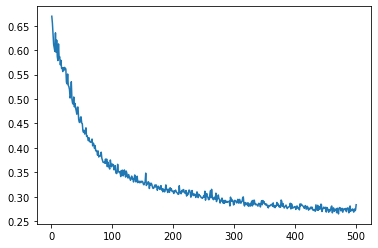

In [9]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,501)]

plt.plot(ep,mse_list1)

In [10]:
with open('mse_alpha_500_file.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [7]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test,create_dataset_for_test_bootstrap


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_pconcs4_3_188_2000_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('results', dataset + '_pconcs4_3_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')




In [8]:

dataset = ['davis', 'kiba'][1]  # dataset selection
model_st = GNNNet.__name__
print('dataset:', dataset)
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0] # gpu selection
print('cuda_name:', cuda_name)

 

dataset: kiba
cuda_name: cuda:0


In [9]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconcs4_3_188_2000_GNNNet_kiba_2.model'
result_file_name = 'results/resul_pconsc4_2_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/rds/user/co-gora1/hpc-work/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 15908 samples...


In [10]:
calculate_metrics(Y, P, dataset)
    

metrics for  kiba
cindex: 0.8488401320811053
cindex2 0.8479211928779065
rm2: 0.617775451272561
mse: 0.23830178
pearson 0.805054622990312
kiba
rmse:0.4881616369606743  mse:0.23830178  pearson:0.805054622990312 spearman:0.8100051649135019 ci:0.8488401320811053 rm2:0.617775451272561


In [9]:

def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(Y, P, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('Experimental', fontsize=30, fontweight='bold')
    plt.ylabel('Predicted', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + '_pconcs4_2_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


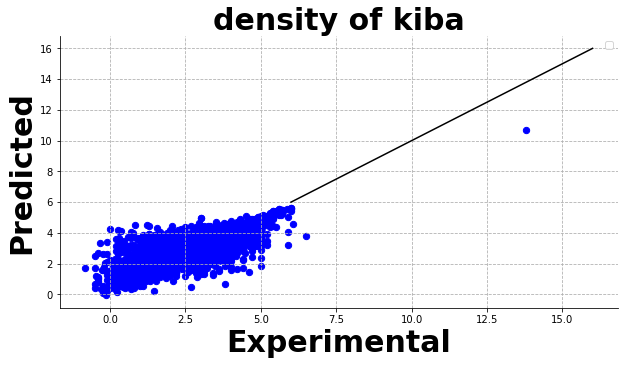

In [12]:
plot_density(Y, P, fold, dataset)

/home/co-gora1/rds/hpc-work/miniconda3/envs/mldd1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


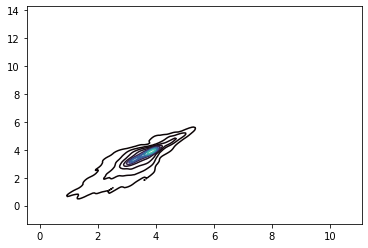

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(P, Y,cmap="mako")
plt.show()

In [16]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconcs4_2_188_2000_GNNNet_kiba_3.model'
result_file_name = 'results/resul_pconsc4_2_188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8532654741913851
cindex2 0.851183496563325
rm2: 0.6265777031973842
mse: 0.22380354
pearson 0.8201320895666028
kiba
rmse:0.4730787831892252  mse:0.22380354  pearson:0.8201320895666028 spearman:0.8168592685499216 ci:0.8532654741913851 rm2:0.6265777031973842


No handles with labels found to put in legend.


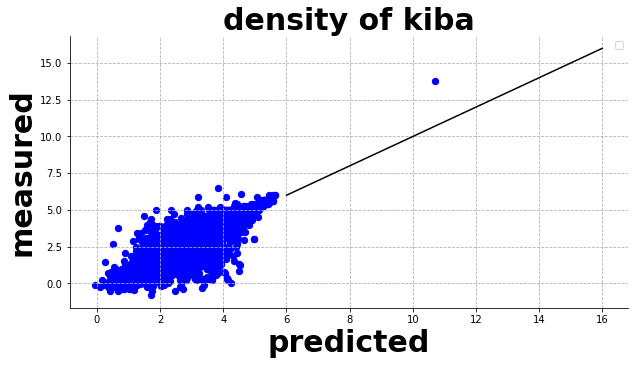

In [18]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


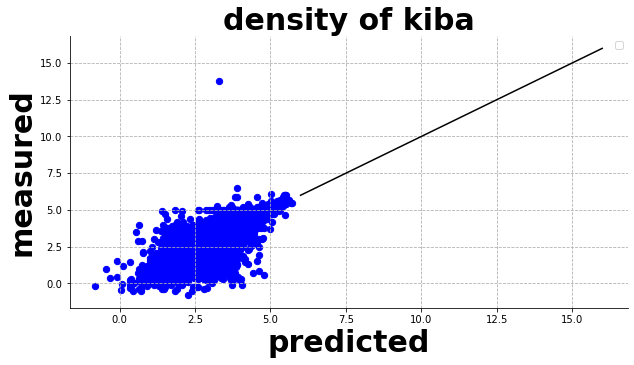

In [15]:
plot_density(Y, P, fold, dataset)

In [18]:
test_loader

In [10]:
Y

array([14.400163, 12.399998, 11.400001, ..., 11.400001, 11.5     ,
       11.5     ], dtype=float32)

In [11]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

In [48]:

my_file = open("alpha500_pred_file.txt", "r")
content = my_file.read()
content=content.splitlines()
content=[float(i) for i in content]
print(content)

[13.572652, 12.826997, 11.444092, 10.318037, 11.341069, 11.559343, 11.85205, 11.203673, 10.334731, 11.582762, 13.900543, 12.97712, 11.691866, 12.792691, 14.458044, 11.520013, 12.257853, 11.212511, 12.006573, 11.880769, 11.1070795, 11.378011, 11.148856, 11.216189, 11.134102, 12.008484, 10.905703, 11.242366, 11.19693, 10.343345, 11.86922, 12.26573, 10.585809, 12.672529, 11.919928, 10.658084, 11.237454, 11.279299, 11.310264, 11.870662, 11.057477, 11.480621, 12.106813, 11.613607, 10.156403, 11.307625, 10.7861595, 11.92269, 11.224873, 12.009879, 10.479592, 11.211487, 11.759775, 11.364248, 11.742957, 12.0676775, 12.2011385, 11.140188, 11.8148365, 11.463266, 11.225105, 11.48033, 12.019633, 11.547219, 11.362604, 12.447442, 10.850902, 11.337198, 10.871161, 11.64067, 11.490308, 11.450138, 11.544379, 10.872649, 12.062119, 11.466935, 11.917785, 11.780647, 11.215674, 12.046588, 11.4404955, 10.219847, 11.889244, 11.15485, 11.559784, 12.427896, 12.339859, 10.860705, 12.2455225, 11.580148, 11.404127, 

In [49]:
P1=np.asarray(content)

In [50]:
P1

array([13.572652 , 12.826997 , 11.444092 , ..., 11.422882 , 11.5344305,
       11.544348 ])

In [52]:
plt.scatter(P,color='blue')

TypeError: scatter() missing 1 required positional argument: 'y'

In [37]:
type(content)

str

In [41]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

No handles with labels found to put in legend.


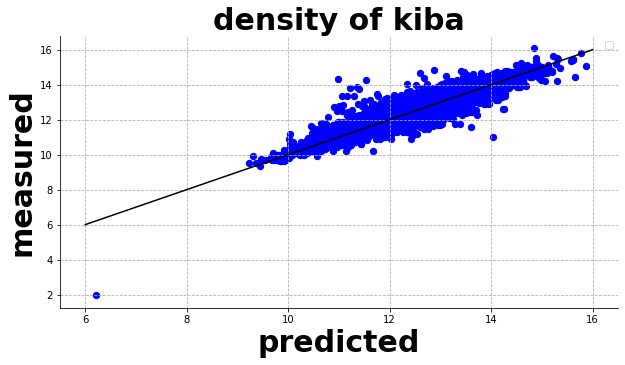

In [53]:
plot_density(P1, P, fold, dataset)

In [12]:
with open('pconsc4_500_gt_file.txt', 'w') as f:
    for item in list(Y):
        f.write("%s\n" % item)

In [13]:
with open('pconsc4_500_pred_file.txt', 'w') as f:
    for item in list(P):
        f.write("%s\n" % item)

No handles with labels found to put in legend.


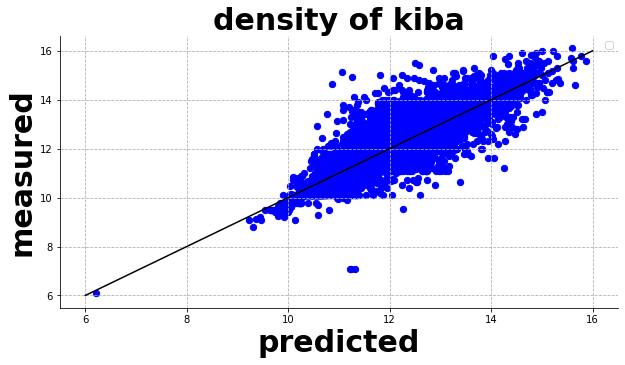

In [54]:
plot_density(Y, P, fold, dataset)

In [58]:
def plot_density1(Y, P,P1, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.scatter(P1, Y, color='green', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + 'alpha v/s pconsc4_500_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


No handles with labels found to put in legend.


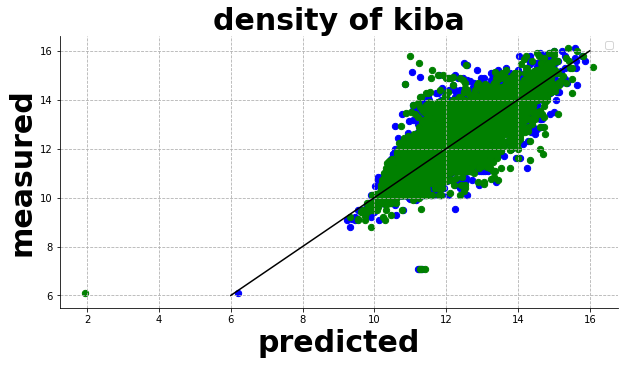

In [59]:
plot_density1(Y, P,P1, fold, dataset)

No handles with labels found to put in legend.


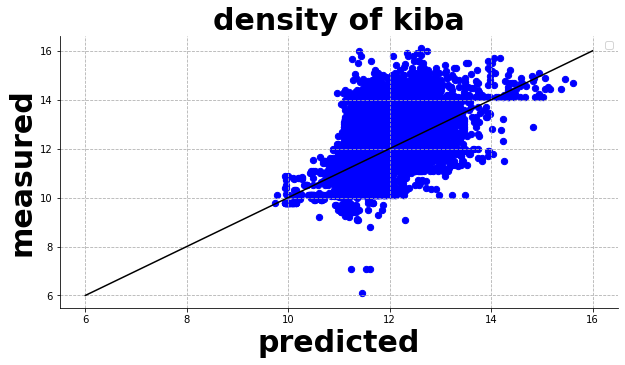

In [13]:
plot_density(Y, P, fold, dataset)

In [ ]:
plot_density(Y, P, fold, dataset)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'

In [8]:

def calculate_metrics1(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
    return cindex,pearson,rmse
#     result_file_name = 'results/result_pconcs4_188_2000_' + model_st + '_' + dataset + '.txt'
#     result_str = ''
#     result_str += dataset + '\r\n'
#     result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
#         pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
#     print(result_str)
#     open(result_file_name, 'w').writelines(result_str)

In [9]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconsc4__188_2000_GNNNet_kiba_1.model'
result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))


GNNNet Loaded


<All keys matched successfully>

In [10]:
rmse1=[]
pearson1=[]
ci1=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(dataset, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y, P = predicting(model, device, test_loader)
    cindex,pearson,rmse=calculate_metrics1(Y, P, dataset)
    print(cindex,pearson,rmse)
    ci1.append(cindex)
    pearson1.append(pearson)
    rmse1.append(rmse)
    

0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8616694988146936
cindex2 0.8587943619216536
rm2: 0.6752159361477695
mse: 0.20807728
pearson 0.8235589360175168
0.8616694988146936 0.8235589360175168 0.4561548878544279
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8511974431511434
cindex2 0.8481224954870757
rm2: 0.577744193184537
mse: 0.22741851
pearson 0.7782227931510187
0.8511974431511434 0.7782227931510187 0.47688417053404253
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8559298108454405
cindex2 0.8586343755756322
rm2: 0.6281498485614005
mse: 0.23502246
pearson 0.8055174588394287
0.8559298108454405 0.8055174588394287 0.48479114622058916
3
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective 

In [11]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
data11 = pd.DataFrame(
{'CI':data_1,
 'Pearson': data_2,
 'RMSE': data_3
})


In [21]:
import seaborn as sns
sns.set_theme(style="whitegrid")

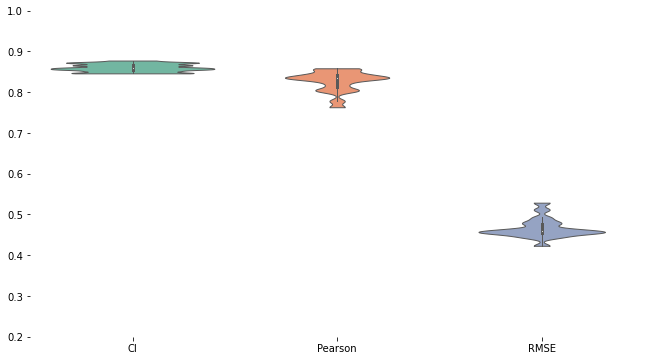

In [13]:
f, ax = plt.subplots(figsize=(11, 6))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2", bw=.2, cut=0, linewidth=1)

# Finalize the figure
ax.set(ylim=(0.2, 1))
sns.despine(left=True, bottom=True)

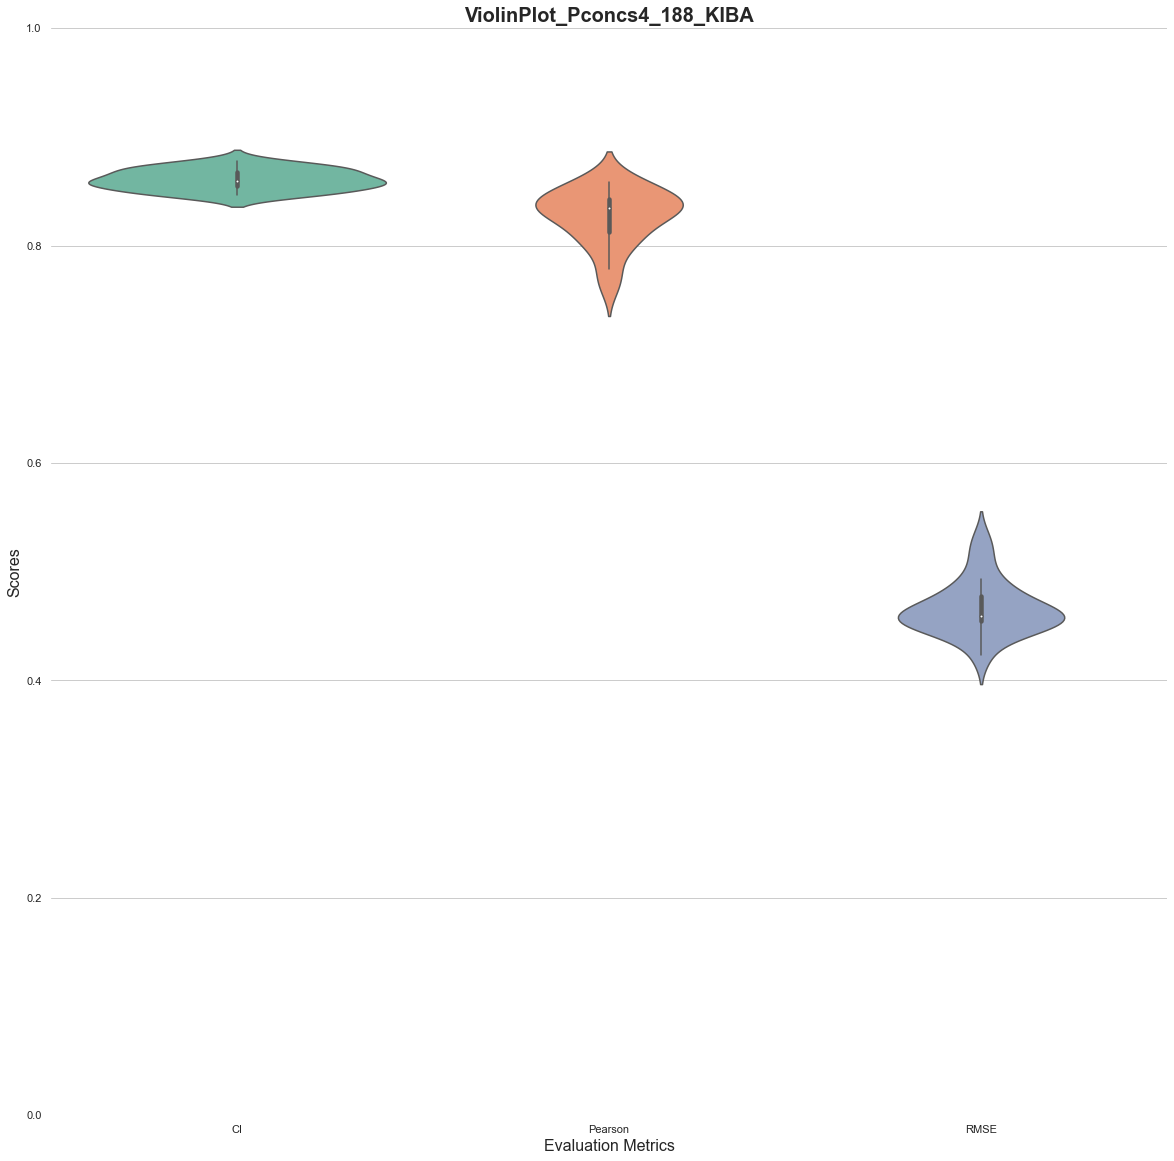

In [50]:
f, ax = plt.subplots(figsize=(20, 20))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0, 1))
ax.set_title
sns.despine(left=True, bottom=True)

ax.set(ylim=(0, 1))
#ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=16)
ax.set_ylabel('Scores',fontsize=16)
ax.set_title('ViolinPlot_Pconcs4_188_KIBA',fontsize=20,fontweight='bold')

plt.savefig(os.path.join('results1',  'violinplot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'violinplot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

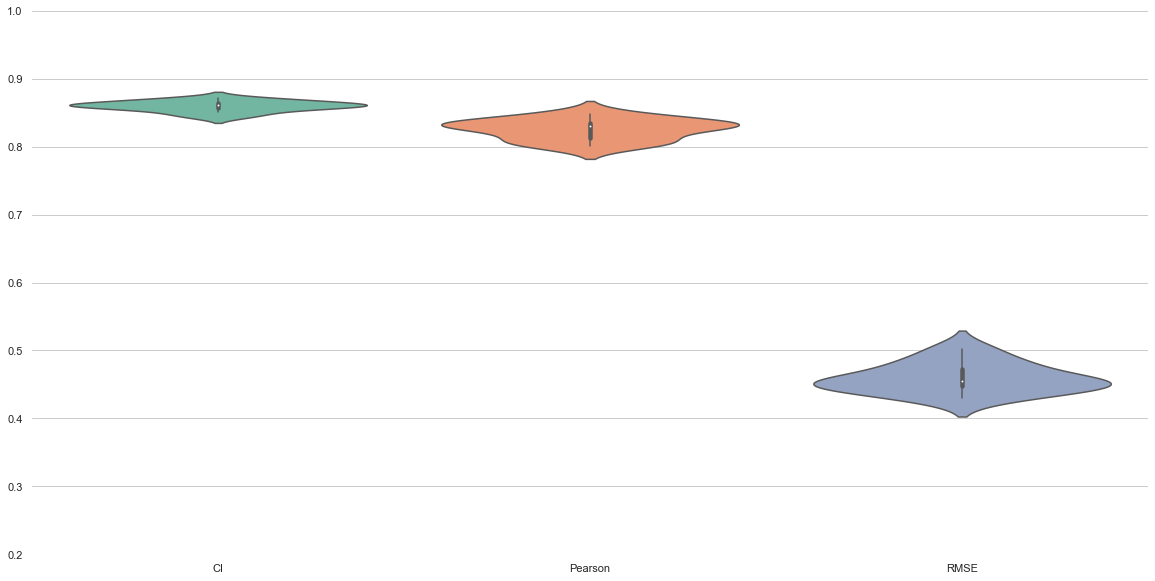

In [62]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2",split=True,scale="width",inner="box")

# Finalize the figure
ax.set(ylim=(0.2, 1))
sns.despine(left=True, bottom=True)

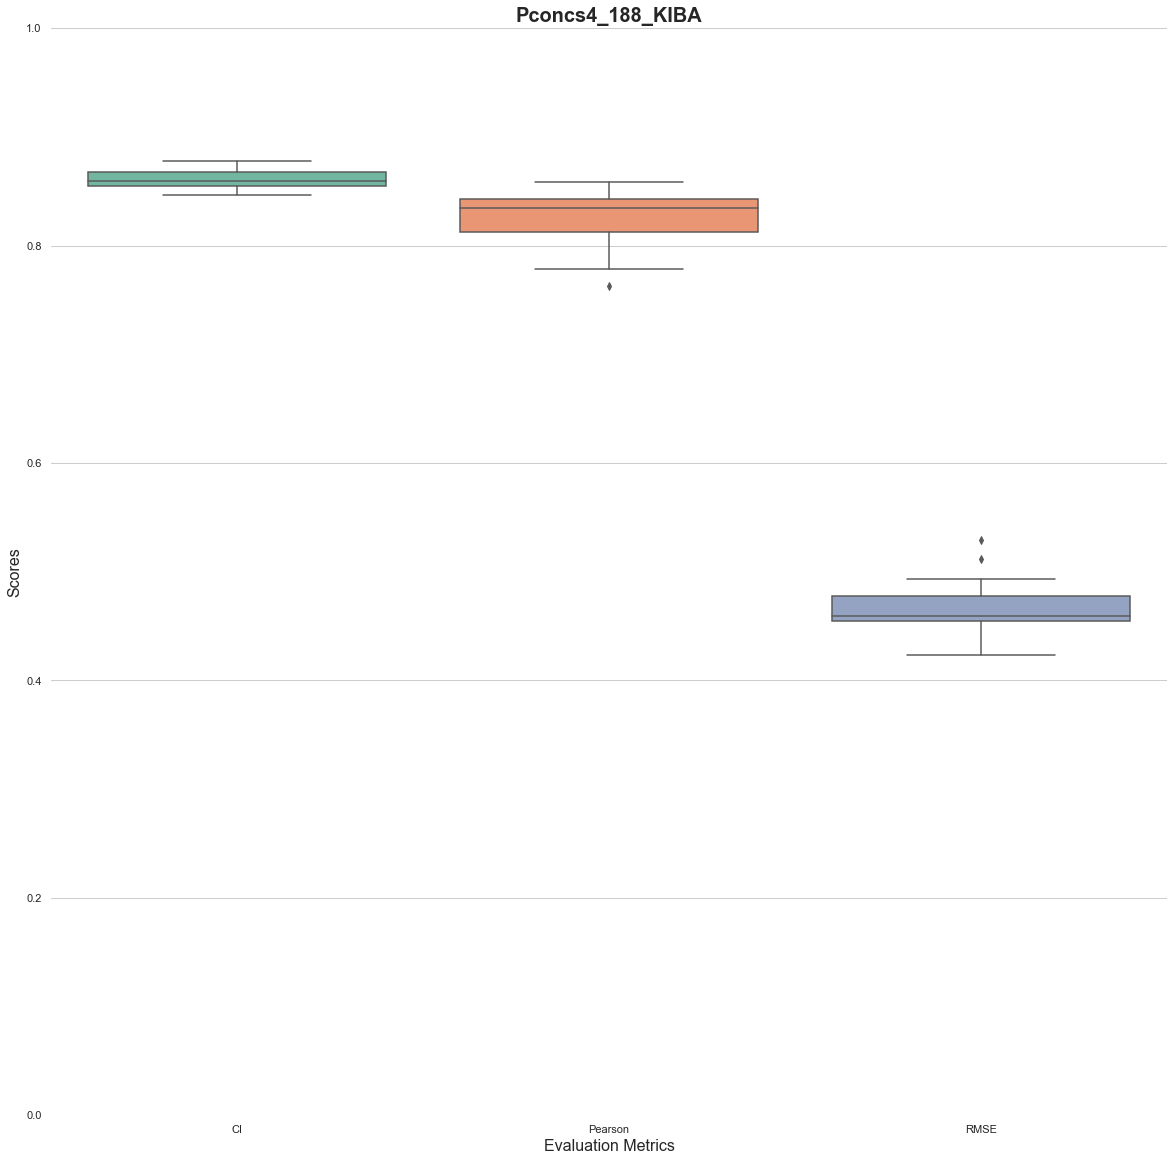

In [48]:
f, ax = plt.subplots(figsize=(20, 20))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=16)
ax.set_ylabel('Scores',fontsize=16)
ax.set_title('Pconcs4_188_KIBA',fontsize=20,fontweight='bold')
sns.despine(left=True, bottom=True)
plt.savefig(os.path.join('results1',  'boxplot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'boxplot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

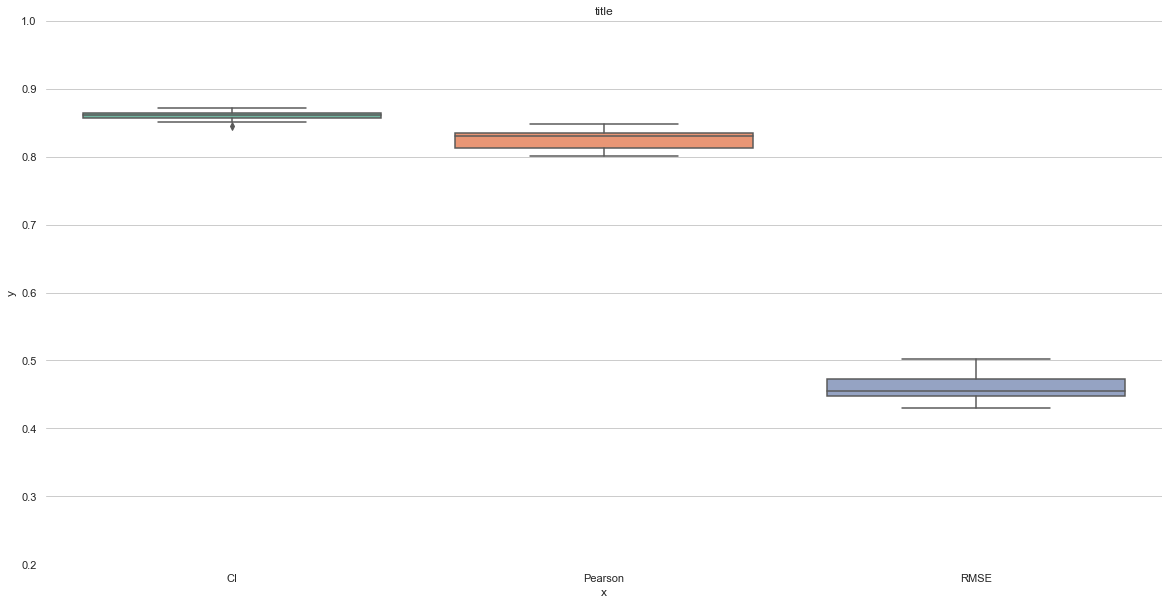

In [43]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0.2, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('title')
sns.despine(left=True, bottom=True)
#sns.despine(offset=10, trim=True)

/tmp/ipykernel_179503/3511795146.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])


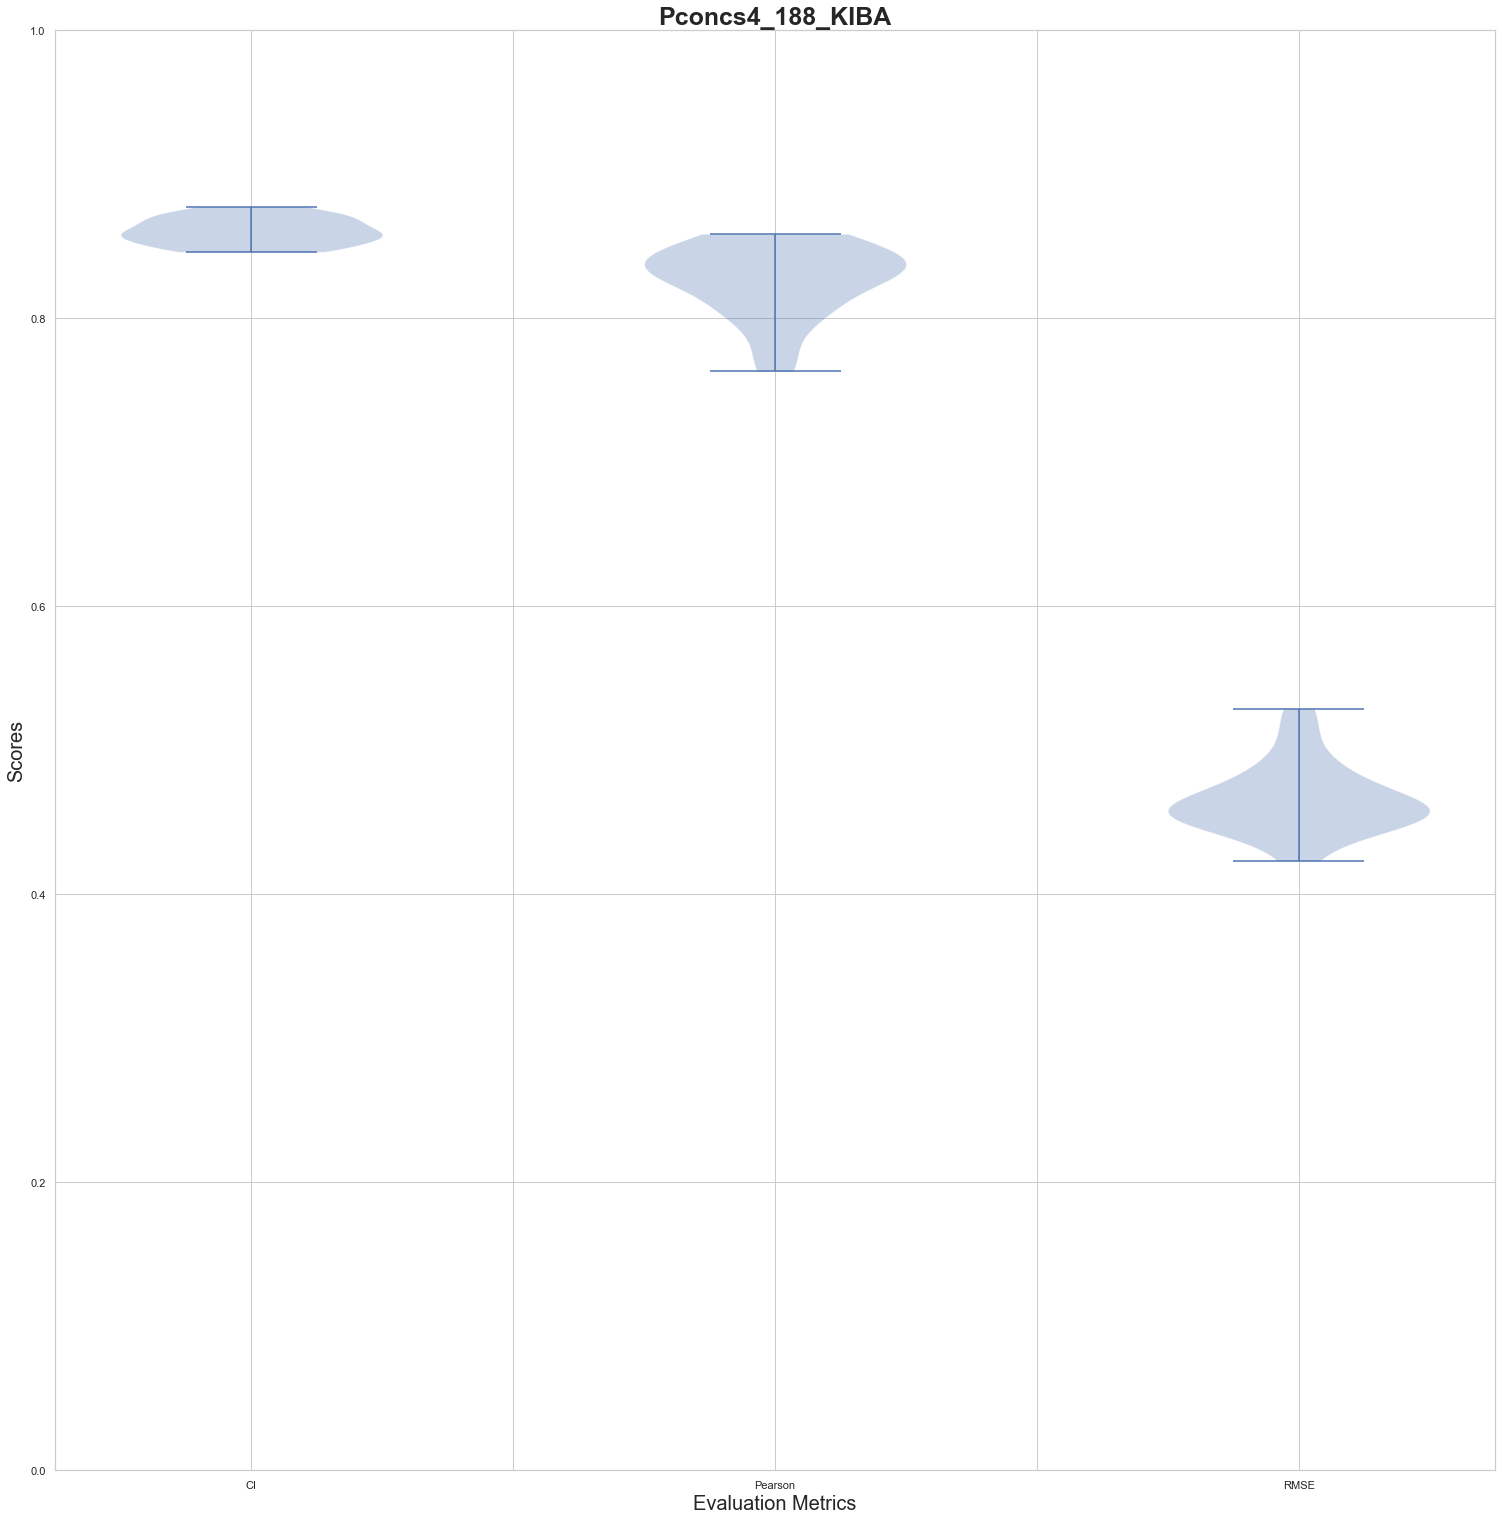

<Figure size 432x288 with 0 Axes>

In [52]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
 
fig = plt.figure(figsize =(20, 20))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1,1])
#ax = fig.add_subplot(111)
ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])
#ax.set_ylim([0, 1])
ax.set(ylim=(0, 1))
#ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Pconcs4_188_KIBA',fontsize=25,fontweight='bold')

bp = ax.violinplot(data)
plt.show()
plt.savefig(os.path.join('results1',  'box_violin_plot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'box_violin_plot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')
# Creating plot


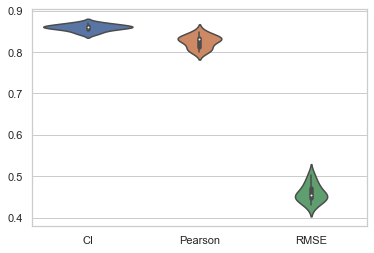

In [65]:
#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots()
# Creating axes instance
#ax = fig.add_axes([0, 0, 1,1])
#ax = fig.add_subplot(111)
#ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
#ax.set_ylim([0.2, 1])
# Creating plot
.violinplot(data=data11,ax=ax)
plt.show()

/tmp/ipykernel_172230/1480089813.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])


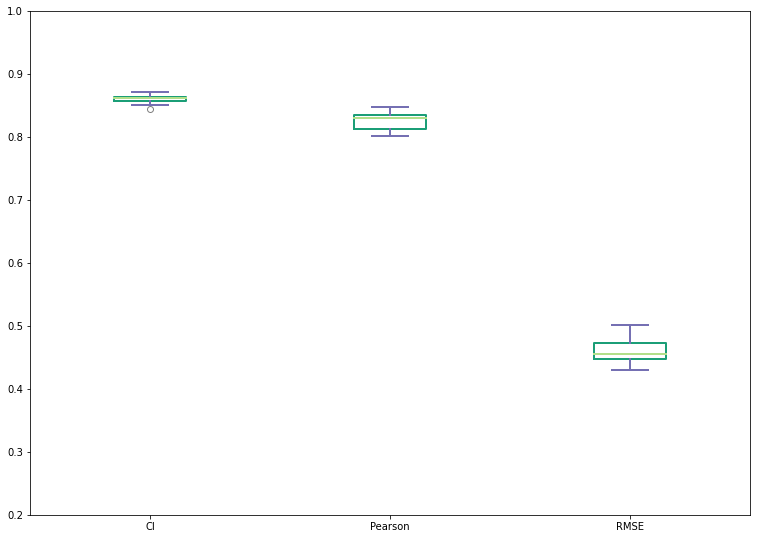

In [17]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
ax.set_ylim([0.2, 1])
# Creating plot
bp = ax.boxplot(data)
# bp = ax.boxplot(data, patch_artist=True)
# ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set(color = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
# show plot
plt.show()

In [8]:
test_data = create_dataset_for_test_bootstrap(dataset, method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


In [9]:
test_data

DTADataset(2000)

In [9]:
test_loader

In [ ]:
Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    

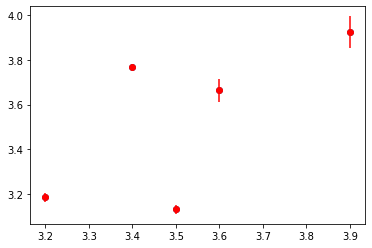

In [20]:
a = [3.199999,3.6,3.4000006,3.8999999,3.50]
b = [3.1865768,3.6635284,3.766081,3.9235876,3.1323996]
plt.scatter(a, b)
d = [0.02, 0.05, 0.01, 0.07,0.02]
  
# you can use color ="r" for red or skip to default as blue
plt.errorbar(a, b, yerr=d, fmt="o", color="r")
  
plt.show()

In [24]:
test_data = create_dataset_for_test_bootstrap(dataset, method,random=30)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y, P = predicting(model, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...


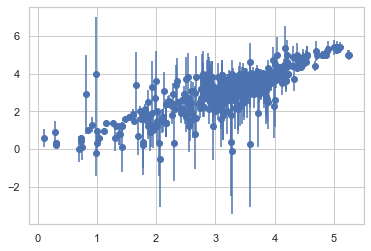

In [30]:
plt.errorbar(P, Y, yerr=Y-P, fmt="o", color="b")
  
plt.show()

In [31]:
type(Y)

numpy.ndarray

In [39]:
n = 200  # for 2 random indices
index = np.random.choice(len(Y), n, replace=False)  

In [40]:
x_random = P[index]
y_random = Y[index]

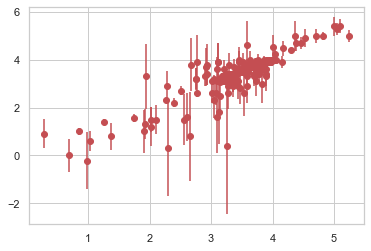

In [41]:
plt.errorbar(x_random, y_random , yerr=y_random -x_random, fmt="o", color="r")
  
plt.show()